In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [3]:
import pandas
from keras_preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from keras.utils import plot_model
from keras.models import load_model
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [4]:
input_shape = (224, 224)
categories_num = 37
batch_size = 32

In [5]:
train_data = pandas.read_csv('../train_pets.csv', usecols=['Category', 'Path'])
val_data = pandas.read_csv('../val_pets.csv', usecols=['Category', 'Path'])

train_datagen = ImageDataGenerator(
        rescale=1. / 255,
        rotation_range=10,
        zoom_range=0.1,
        brightness_range=(0.7, 1.3),
        horizontal_flip=True
)
val_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='.',
        x_col='Path',
        y_col='Category',
        class_mode='categorical',
        target_size=input_shape,
        interpolation='bicubic',
        batch_size=batch_size)

val_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='.',
        x_col='Path',
        y_col='Category',
        class_mode='categorical',
        target_size=input_shape,
        interpolation='bicubic',
        batch_size=batch_size)

Found 6434 validated image filenames belonging to 37 classes.
Found 333 validated image filenames belonging to 37 classes.


In [6]:
def plot_history(histories, save=False, folder=""):
    # Plot training & validation accuracy values
    plt.figure(1)
    for i in range(len(histories)):
        plt.plot(histories[i].history['categorical_accuracy'])
        plt.plot(histories[i].history['val_categorical_accuracy'])
        plt.title('Model accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper left')

    # Plot training & validation loss values
    plt.figure(2)
    for i in range(len(histories)):
        plt.plot(histories[i].history['loss'])
        plt.plot(histories[i].history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper left')

    plt.show()

In [7]:
from keras.models import Model
from keras.applications.resnet50 import ResNet50
from keras.layers import *
from keras.metrics import categorical_accuracy
from keras.optimizers import Adam

def get_model(weights, trainable, lr):
    resnet = ResNet50(weights=weights, include_top=False)

    x = resnet.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.7)(x)
#     x = Dense(512, activation='relu')(x)
    predictions = Dense(categories_num, activation='softmax')(x)

    model = Model(inputs=resnet.input, outputs=predictions)

    for layer in resnet.layers:
        layer.trainable = trainable

    model.compile(optimizer=Adam(lr=lr), loss='categorical_crossentropy', metrics=[categorical_accuracy])
#     model.summary()
    
    return model

### Первый тип переноса обучения

Берем предобученную сеть **ResNet-50**, заменяем последние слои для классификации на свои для последующего обучения. Всем слоям из **ResNet** ставим флаг *trainable=False*.

In [9]:
model = get_model(weights='imagenet', trainable=False, lr=0.1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/10
 - 32s - loss: 15.6564 - categorical_accuracy: 0.0252 - val_loss: 15.6648 - val_categorical_accuracy: 0.0281
Epoch 2/10
 - 26s - loss: 15.7222 - categorical_accuracy: 0.0246 - val_loss: 15.6897 - val_categorical_accuracy: 0.0266
Epoch 3/10
 - 26s - loss: 15.7196 - categorical_accuracy: 0.0247 - val_loss: 15.6362 - val_categorical_accuracy: 0.0299
Epoch 4/10
 - 26s - loss: 15.7247 - categorical_accuracy: 0.0244 - val_loss: 15.6362 - val_categorical_accuracy: 0.0299
Epoch 5/10
 - 26s - loss: 15.7196 - categorical_accuracy: 0.0247 - val_loss: 15.7433 - val_categorical_accuracy: 0.0233
Epoch 6/10
 - 26s - loss: 15.7297 - categorical_accuracy: 0.0241 - val_loss: 15.8504 - val_categorical_accuracy: 0.0166
Epoch 7/10
 - 25s - loss: 15.7121 - categorical_accuracy: 0.0252 - val_loss: 15.5291 - val_categorical_accuracy: 0.0365
Epoch 8/10
 - 25s - loss: 15.7222 - categorical_accuracy: 0.0246 -

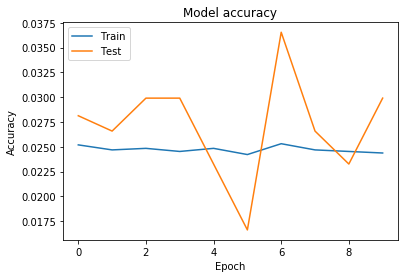

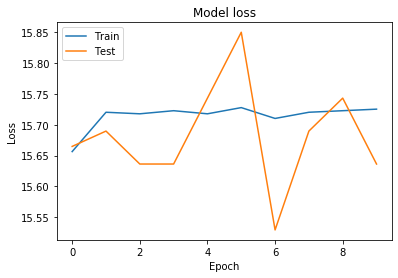

In [10]:
history_0 = model.fit_generator(
            generator=train_generator,
            steps_per_epoch=train_generator.n // batch_size,
            validation_data=val_generator,
            validation_steps=val_generator.n // batch_size,
            epochs=10,
            verbose=2,
            callbacks=[EarlyStopping(patience=4)])

plot_history([history_0])

In [11]:
model = get_model(weights='imagenet', trainable=False, lr=0.01)

Epoch 1/10
 - 31s - loss: 4.1697 - categorical_accuracy: 0.4398 - val_loss: 8.8194 - val_categorical_accuracy: 0.0233
Epoch 2/10
 - 27s - loss: 3.7123 - categorical_accuracy: 0.5794 - val_loss: 11.6136 - val_categorical_accuracy: 0.0312
Epoch 3/10
 - 26s - loss: 3.7835 - categorical_accuracy: 0.6197 - val_loss: 13.2313 - val_categorical_accuracy: 0.0266
Epoch 4/10
 - 26s - loss: 3.7324 - categorical_accuracy: 0.6281 - val_loss: 11.0395 - val_categorical_accuracy: 0.0332
Epoch 5/10
 - 26s - loss: 3.8921 - categorical_accuracy: 0.6444 - val_loss: 13.2650 - val_categorical_accuracy: 0.0066


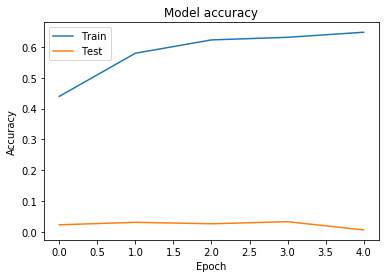

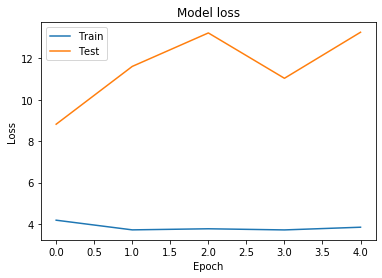

In [12]:
history_1 = model.fit_generator(
            generator=train_generator,
            steps_per_epoch=train_generator.n // batch_size,
            validation_data=val_generator,
            validation_steps=val_generator.n // batch_size,
            epochs=10,
            verbose=2,
            callbacks=[EarlyStopping(patience=4)])

plot_history([history_1])

In [13]:
model = get_model(weights='imagenet', trainable=False, lr=0.001)

Epoch 1/10
 - 31s - loss: 2.5847 - categorical_accuracy: 0.3169 - val_loss: 4.1728 - val_categorical_accuracy: 0.0166
Epoch 2/10
 - 26s - loss: 1.2697 - categorical_accuracy: 0.6143 - val_loss: 4.4100 - val_categorical_accuracy: 0.0266
Epoch 3/10
 - 26s - loss: 1.0392 - categorical_accuracy: 0.6808 - val_loss: 4.5309 - val_categorical_accuracy: 0.0332
Epoch 4/10
 - 26s - loss: 0.9093 - categorical_accuracy: 0.7203 - val_loss: 4.5677 - val_categorical_accuracy: 0.0332
Epoch 5/10
 - 26s - loss: 0.8098 - categorical_accuracy: 0.7449 - val_loss: 4.5214 - val_categorical_accuracy: 0.0166


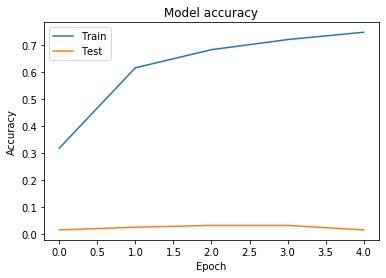

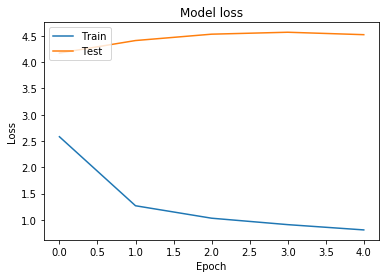

In [14]:
history_2 = model.fit_generator(
            generator=train_generator,
            steps_per_epoch=train_generator.n // batch_size,
            validation_data=val_generator,
            validation_steps=val_generator.n // batch_size,
            epochs=10,
            verbose=2,
            callbacks=[EarlyStopping(patience=4)])

plot_history([history_2])

In [15]:
model = get_model(weights='imagenet', trainable=False, lr=0.0001)

Epoch 1/10
 - 33s - loss: 4.4036 - categorical_accuracy: 0.0512 - val_loss: 3.9462 - val_categorical_accuracy: 0.0266
Epoch 2/10
 - 27s - loss: 3.5096 - categorical_accuracy: 0.1281 - val_loss: 3.9193 - val_categorical_accuracy: 0.0299
Epoch 3/10
 - 26s - loss: 2.8964 - categorical_accuracy: 0.2195 - val_loss: 3.9206 - val_categorical_accuracy: 0.0281
Epoch 4/10
 - 26s - loss: 2.4560 - categorical_accuracy: 0.3060 - val_loss: 3.9427 - val_categorical_accuracy: 0.0266
Epoch 5/10
 - 26s - loss: 2.1548 - categorical_accuracy: 0.3800 - val_loss: 3.9050 - val_categorical_accuracy: 0.0332
Epoch 6/10
 - 26s - loss: 1.9239 - categorical_accuracy: 0.4318 - val_loss: 3.9154 - val_categorical_accuracy: 0.0266
Epoch 7/10
 - 26s - loss: 1.7582 - categorical_accuracy: 0.4745 - val_loss: 3.9369 - val_categorical_accuracy: 0.0266
Epoch 8/10
 - 26s - loss: 1.6141 - categorical_accuracy: 0.5123 - val_loss: 3.9303 - val_categorical_accuracy: 0.0266
Epoch 9/10
 - 26s - loss: 1.4925 - categorical_accuracy:

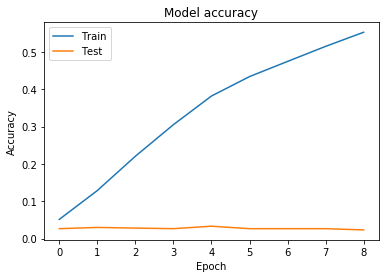

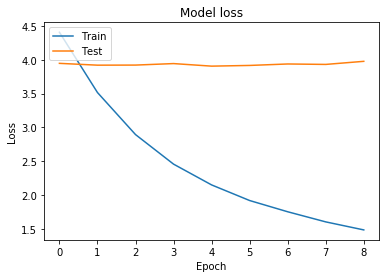

In [16]:
history_3 = model.fit_generator(
            generator=train_generator,
            steps_per_epoch=train_generator.n // batch_size,
            validation_data=val_generator,
            validation_steps=val_generator.n // batch_size,
            epochs=10,
            verbose=2,
            callbacks=[EarlyStopping(patience=4)])

plot_history([history_3])

In [17]:
model.save('first_type.h5')

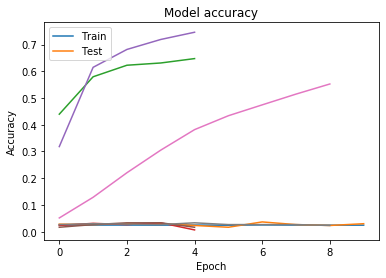

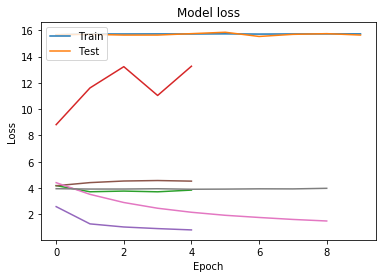

In [18]:
plot_history([history_0, history_1, history_2, history_3])

### Второй тип переноса обучения

Берем предобученную сеть **ResNet-50**, заменяем последние слои для классификации на свои. Всем слоям из **ResNet** ставим флаг *trainable=True*, для их дообучения под нашу задачу.

In [9]:
model = get_model(weights='imagenet', trainable=True, lr=0.0001)

Epoch 1/10
 - 107s - loss: 1.9424 - categorical_accuracy: 0.4759 - val_loss: 0.7127 - val_categorical_accuracy: 0.7741
Epoch 2/10
 - 88s - loss: 0.6296 - categorical_accuracy: 0.8075 - val_loss: 0.6435 - val_categorical_accuracy: 0.7940
Epoch 3/10
 - 88s - loss: 0.3597 - categorical_accuracy: 0.8904 - val_loss: 0.5027 - val_categorical_accuracy: 0.8605
Epoch 4/10
 - 88s - loss: 0.2491 - categorical_accuracy: 0.9206 - val_loss: 0.6007 - val_categorical_accuracy: 0.8439
Epoch 5/10
 - 88s - loss: 0.2006 - categorical_accuracy: 0.9405 - val_loss: 0.4785 - val_categorical_accuracy: 0.8738
Epoch 6/10
 - 88s - loss: 0.1422 - categorical_accuracy: 0.9600 - val_loss: 0.6446 - val_categorical_accuracy: 0.8405
Epoch 7/10
 - 88s - loss: 0.1201 - categorical_accuracy: 0.9641 - val_loss: 0.7196 - val_categorical_accuracy: 0.7940
Epoch 8/10
 - 88s - loss: 0.1246 - categorical_accuracy: 0.9605 - val_loss: 0.5734 - val_categorical_accuracy: 0.8594
Epoch 9/10
 - 87s - loss: 0.1147 - categorical_accuracy

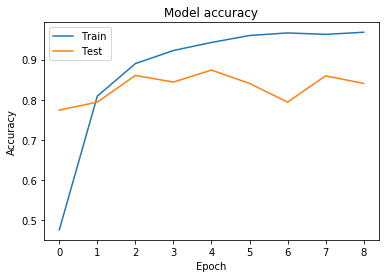

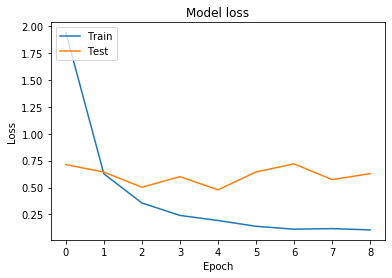

In [25]:
history_1 = model.fit_generator(
            generator=train_generator,
            steps_per_epoch=train_generator.n // batch_size,
            validation_data=val_generator,
            validation_steps=val_generator.n // batch_size,
            epochs=10,
            verbose=2,
            callbacks=[EarlyStopping(patience=4)])

plot_history([history_1])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/10
 - 159s - loss: 2.0303 - categorical_accuracy: 0.4633 - val_loss: 0.7955 - val_categorical_accuracy: 0.7719
Epoch 2/10
 - 135s - loss: 0.7064 - categorical_accuracy: 0.7820 - val_loss: 0.5910 - val_categorical_accuracy: 0.8306
Epoch 3/10
 - 143s - loss: 0.4767 - categorical_accuracy: 0.8539 - val_loss: 0.4574 - val_categorical_accuracy: 0.8605
Epoch 4/10
 - 139s - loss: 0.3486 - categorical_accuracy: 0.8932 - val_loss: 0.4896 - val_categorical_accuracy: 0.8638
Epoch 5/10
 - 142s - loss: 0.2731 - categorical_accuracy: 0.9147 - val_loss: 0.5646 - val_categorical_accuracy: 0.8339
Epoch 6/10
 - 142s - loss: 0.2120 - categorical_accuracy: 0.9336 - val_loss: 0.5240 - val_categorical_accuracy: 0.8272
Epoch 7/10
 - 141s - loss: 0.1828 - categorical_accuracy: 0.9448 - val_loss: 0.5437 - val_categorical_accuracy: 0.8439


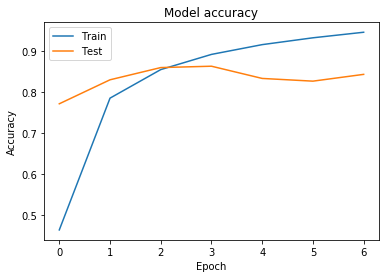

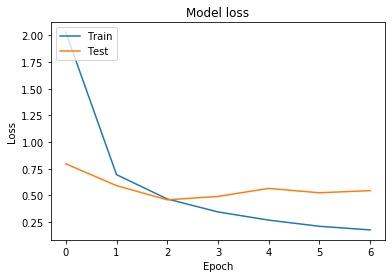

In [10]:
history_2 = model.fit_generator(
            generator=train_generator,
            steps_per_epoch=train_generator.n // batch_size,
            validation_data=val_generator,
            validation_steps=val_generator.n // batch_size,
            epochs=10,
            verbose=2,
            callbacks=[EarlyStopping(patience=4)])

plot_history([history_2])

### Третий тип переноса обучения

Берем необученную сеть **ResNet-50**, заменяем последние слои для классификации на свои. Пытаемся обучить полученную архитектуру с нуля.

Epoch 1/100
 - 133s - loss: 4.2812 - categorical_accuracy: 0.0272 - val_loss: 10.3192 - val_categorical_accuracy: 0.0233
Epoch 2/100
 - 118s - loss: 4.1185 - categorical_accuracy: 0.0396 - val_loss: 14.9198 - val_categorical_accuracy: 0.0332
Epoch 3/100
 - 116s - loss: 4.0485 - categorical_accuracy: 0.0521 - val_loss: 15.6193 - val_categorical_accuracy: 0.0233
Epoch 4/100
 - 118s - loss: 3.8858 - categorical_accuracy: 0.0678 - val_loss: 11.0630 - val_categorical_accuracy: 0.0299
Epoch 5/100
 - 118s - loss: 3.8563 - categorical_accuracy: 0.0690 - val_loss: 3.6434 - val_categorical_accuracy: 0.0631
Epoch 6/100
 - 117s - loss: 3.7736 - categorical_accuracy: 0.0707 - val_loss: 6.0051 - val_categorical_accuracy: 0.0598
Epoch 7/100
 - 118s - loss: 3.7423 - categorical_accuracy: 0.0768 - val_loss: 3.5560 - val_categorical_accuracy: 0.0664
Epoch 8/100
 - 117s - loss: 3.7278 - categorical_accuracy: 0.0794 - val_loss: 3.4587 - val_categorical_accuracy: 0.0598
Epoch 9/100
 - 117s - loss: 3.6195 -

Epoch 68/100
 - 116s - loss: 0.7906 - categorical_accuracy: 0.7482 - val_loss: 2.1686 - val_categorical_accuracy: 0.4751
Epoch 69/100
 - 118s - loss: 0.8006 - categorical_accuracy: 0.7416 - val_loss: 2.8278 - val_categorical_accuracy: 0.4086
Epoch 70/100
 - 117s - loss: 0.7617 - categorical_accuracy: 0.7592 - val_loss: 1.9944 - val_categorical_accuracy: 0.5017
Epoch 71/100
 - 117s - loss: 0.7021 - categorical_accuracy: 0.7763 - val_loss: 1.9282 - val_categorical_accuracy: 0.4884
Epoch 72/100
 - 118s - loss: 0.6634 - categorical_accuracy: 0.7879 - val_loss: 1.9332 - val_categorical_accuracy: 0.5581
Epoch 73/100
 - 118s - loss: 0.6055 - categorical_accuracy: 0.8063 - val_loss: 1.6848 - val_categorical_accuracy: 0.5282
Epoch 74/100
 - 118s - loss: 0.5884 - categorical_accuracy: 0.8069 - val_loss: 1.9437 - val_categorical_accuracy: 0.5116
Epoch 75/100
 - 126s - loss: 0.5254 - categorical_accuracy: 0.8265 - val_loss: 2.2377 - val_categorical_accuracy: 0.5083
Epoch 76/100
 - 131s - loss: 0.5

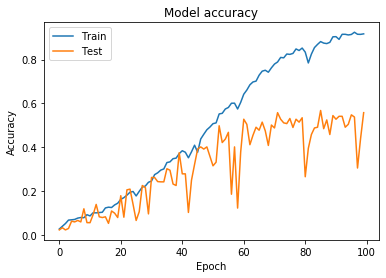

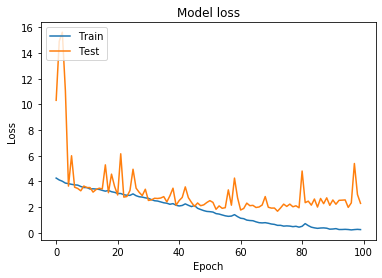

In [10]:
model = get_model(weights=None, trainable=True, lr=0.001)

history_3 = model.fit_generator(
            generator=train_generator,
            steps_per_epoch=train_generator.n // batch_size,
            validation_data=val_generator,
            validation_steps=val_generator.n // batch_size,
            epochs=100,
            verbose=2,
#             callbacks=[EarlyStopping(patience=10)]
)

plot_history([history_3])

Epoch 1/100
 - 152s - loss: 4.9022 - categorical_accuracy: 0.0317 - val_loss: 5.5468 - val_categorical_accuracy: 0.0332
Epoch 2/100
 - 154s - loss: 4.1413 - categorical_accuracy: 0.0353 - val_loss: 4.0230 - val_categorical_accuracy: 0.0375
Epoch 3/100
 - 154s - loss: 4.0398 - categorical_accuracy: 0.0477 - val_loss: 4.9526 - val_categorical_accuracy: 0.0532
Epoch 4/100
 - 150s - loss: 3.9188 - categorical_accuracy: 0.0586 - val_loss: 4.4101 - val_categorical_accuracy: 0.0731
Epoch 5/100
 - 151s - loss: 3.8428 - categorical_accuracy: 0.0673 - val_loss: 4.0977 - val_categorical_accuracy: 0.0432
Epoch 6/100
 - 153s - loss: 3.7870 - categorical_accuracy: 0.0802 - val_loss: 3.4598 - val_categorical_accuracy: 0.0764
Epoch 7/100
 - 157s - loss: 3.7088 - categorical_accuracy: 0.0849 - val_loss: 3.4014 - val_categorical_accuracy: 0.0698
Epoch 8/100
 - 147s - loss: 3.6096 - categorical_accuracy: 0.1007 - val_loss: 4.0465 - val_categorical_accuracy: 0.1030
Epoch 9/100
 - 155s - loss: 3.5128 - cat

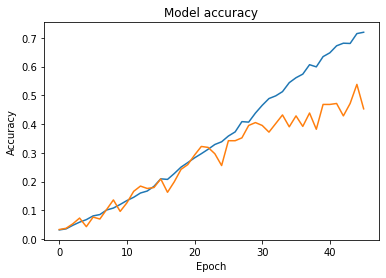

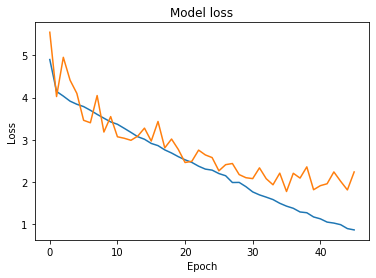

In [7]:
model = get_model(weights=None, trainable=True)

history_3 = model.fit_generator(
            generator=train_generator,
            steps_per_epoch=train_generator.n // batch_size,
            validation_data=val_generator,
            validation_steps=val_generator.n // batch_size,
            epochs=100,
            verbose=1,
            callbacks=[EarlyStopping(patience=10)])

plot_history([history_3])

In [7]:
model.save('resnet-pool-drop07.h5')

### Тестирование

In [14]:
best_model_1 = load_model('first_type.h5')
best_model_2 = load_model('second_type_type.h5')
best_model_3 = load_model('third_type.h5')

In [15]:
test_data = pandas.read_csv('../test_pets.csv', usecols=['Category', 'Path'])
test_datagen = ImageDataGenerator(rescale=1. / 255)
test_generator = test_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='.',
        x_col='Path',
        y_col='Category',
        class_mode='categorical',
        target_size=input_shape,
        interpolation='bicubic',
        batch_size=batch_size)

Found 333 validated image filenames belonging to 37 classes.


In [16]:
history_1 = best_model_1.evaluate_generator(
        test_generator,
        steps=test_generator.n // batch_size,
        verbose=1)

history_2 = best_model_2.evaluate_generator(
        test_generator,
        steps=test_generator.n // batch_size,
        verbose=1)

history_3 = best_model_3.evaluate_generator(
        test_generator,
        steps=test_generator.n // batch_size,
        verbose=1)

print(f'Test loss: {history_1[0]}, Test accuracy: {history_1[1]}')
print(f'Test loss: {history_2[0]}, Test accuracy: {history_2[1]}')
print(f'Test loss: {history_3[0]}, Test accuracy: {history_3[1]}')

10/10 [==============================] - 7s 682ms/step
Test loss: 3.9458717584609984, Test accuracy: 0.025
Test loss: 0.5573712065568398, Test accuracy: 0.8338870435854129
Test loss: 2.1882532712233025, Test accuracy: 0.5747508308618172


Original: american_bulldog

1:
Sphynx 0.14406468
British_Shorthair 0.066880845
Birman 0.06326203

2:
american_bulldog 0.8987125
wheaten_terrier 0.047516923
american_pit_bull_terrier 0.020723468

3:
american_bulldog 0.48303205
chihuahua 0.19517869
Abyssinian 0.13826469


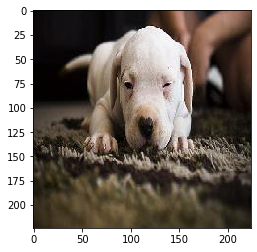

In [24]:
sample = test_generator.next()
image_array = sample[0]
categories_dict = {value: key for key, value in test_generator.class_indices.items()}
category = categories_dict[np.argmax(sample[1][0])]

predictions_1 = best_model_1.predict(image_array)[0]
predictions_2 = best_model_2.predict(image_array)[0]
predictions_3 = best_model_3.predict(image_array)[0]

best_args_1 = np.argsort(predictions_1)[::-1][:3]
best_args_2 = np.argsort(predictions_2)[::-1][:3]
best_args_3 = np.argsort(predictions_3)[::-1][:3]

print(f'Original: {category}')

print('\n1:')
for i in best_args_1:
    print(categories_dict[i], predictions_1[i])
    
print('\n2:')
for i in best_args_2:
    print(categories_dict[i], predictions_2[i])

print('\n3:')
for i in best_args_3:
    print(categories_dict[i], predictions_3[i])

plt.imshow(image_array[0])